<a href="https://colab.research.google.com/github/Kuzay3t/3D_Image_Reconstruction/blob/main/3d_Reconstruction_ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
import pandas as pd
import zipfile
import os
from google.colab import drive
import zipfile
import open3d as o3d
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import plotly.graph_objects as go

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
print(os.listdir('/content/drive/My Drive'))

['FINANCIAL LITERACY CERTIFICATE.pdf', 'KUZAYET BMC.pdf', 'GST 208 RECEIPT.pdf', 'VID-20240508-WA0014.mp4', 'BAGAI GLORY RESUME.pdf', 'BAGAI GLORY HEADSHOT.jpeg', '300LVL 2ND SEMESTER', 'project proposal template', 'RENUE DOCUMENT', 'Colab Notebooks', 'archive (1).zip', 'archive.zip']


In [ ]:
zip_path = '/content/drive/My Drive/archive.zip'


In [ ]:
extract_path = '/content/ModelNet10'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
#Setting path to unzipped dataset
root_dir = '/content/ModelNet10/ModelNet10'
category = 'chair'
model_dir = os.path.join(root_dir, category, 'train')
sample_file = [f for f in os.listdir(model_dir) if f.endswith('.off')][0]
file_path = os.path.join(model_dir, sample_file)

In [ ]:
print(os.listdir('/content/ModelNet10'))

['metadata_modelnet10.csv', 'ModelNet10']


## Data Exploration

In [ ]:
#Listig the contents of the extracted ModelNet10 directory
print(os.listdir(extract_path))

['metadata_modelnet10.csv', 'ModelNet10']


In [ ]:
#ModelNet10 has two subdirectories: 'train' and 'test'
train_path = os.path.join(extract_path, 'ModelNet10')
test_path = os.path.join(extract_path, 'ModelNet10')

In [ ]:
#Listing the categories available in the training set
categories = os.listdir(train_path)
print("Available categories:", categories)

Available categories: ['desk', 'bathtub', 'toilet', 'sofa', 'table', 'bed', 'night_stand', 'chair', 'monitor', 'dresser']


## **Loading and Visualizing the 3D Model**

In [ ]:
def load_and_visualize_model(category='chair', sample_index=0):
    """
    Load and visualize a 3D model from ModelNet10

    Args:
        category (str): Category of the model to load (e.g., 'chair', 'table')
        sample_index (int): Index of the model to load within its category
    """
    # Constructing the path to the sample model
    category_train_path = os.path.join(train_path, category, 'train')
    model_files = [f for f in os.listdir(category_train_path) if f.endswith('.off')]
    model_file = os.path.join(category_train_path, model_files[sample_index])

    # Loading the mesh file
    mesh = o3d.io.read_triangle_mesh(model_file)

    # Printing basic information about the mesh
    print(f"Loaded {category} model: {model_files[sample_index]}") # Corrected variable name
    print("Number of vertices:", len(mesh.vertices))
    print("Number of triangles:", len(mesh.triangles))

    # Computing vertex normals for better visualization
    mesh.compute_vertex_normals()

    # Visualizing the mesh
    o3d.visualization.draw_geometries([mesh], window_name=f"Original {category}")

In [ ]:
load_and_visualize_model('chair', 0)

Loaded chair model: chair_0396.off
Number of vertices: 3644
Number of triangles: 4088
[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


## Data Preprocessing

In [ ]:
def preprocess_model(mesh, num_points=1024):
    """
    Convert mesh to point cloud and normalize it

    Args:
        mesh: Open3D mesh object
        num_points: Number of points to sample from the mesh

    Returns:
        point_cloud: Normalized point cloud as numpy array
    """
    # Converting mesh to point cloud by sampling points
    pcd = mesh.sample_points_poisson_disk(number_of_points=num_points)

    # Getting points as numpy array
    points = np.asarray(pcd.points)

    # Normalizing points to [-1, 1] range
    centroid = np.mean(points, axis=0)
    points -= centroid
    max_dist = np.max(np.sqrt(np.sum(points**2, axis=1)))
    points /= max_dist

    return points



In [ ]:

chair_files = [f for f in os.listdir(os.path.join(train_path, 'chair', 'train')) if f.endswith('.off')]
if chair_files:
    sample_chair_file = chair_files[0]
    mesh = o3d.io.read_triangle_mesh(os.path.join(train_path, 'chair', 'train', sample_chair_file))

    if mesh.has_triangles():
        point_cloud = preprocess_model(mesh)
        print("Normalized point cloud shape:", point_cloud.shape)
    else:
        print(f"Loaded mesh from {sample_chair_file} has no triangles and cannot be processed.")
else:
    print(f"No .off files found in {os.path.join(train_path, 'chair', 'train')}")

Normalized point cloud shape: (1024, 3)


## Adding Artificial Noise

In [ ]:
def add_noise_to_point_cloud(points, noise_level=0.05):
    """
    Add Gaussian noise to a point cloud

    Args:
        points: Input point cloud (N x 3)
        noise_level: Standard deviation of Gaussian noise

    Returns:
        noisy_points: Noisy version of input point cloud
    """
    noise = np.random.normal(scale=noise_level, size=points.shape)
    noisy_points = points + noise


    noisy_points = np.clip(noisy_points, -1, 1)

    return noisy_points



In [ ]:

noisy_pc = add_noise_to_point_cloud(point_cloud)
print("Noisy point cloud shape:", noisy_pc.shape)

Noisy point cloud shape: (1024, 3)


## Building a Denoising Model

In [ ]:
class PointNetDenoiser(nn.Module):
    def __init__(self, num_points=1024):
        super(PointNetDenoiser, self).__init__()

        # Shared MLP for point features
        self.mlp1 = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        # Second MLP for higher-level features
        self.mlp2 = nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )

        # Decoder MLP to get back to 3D coordinates
        self.decoder = nn.Sequential(
            nn.Conv1d(1088, 512, 1),  # 1024 (global) + 64 (local) = 1088
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 256, 1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 3, 1)  # Output 3D coordinates
        )

    def forward(self, x):
        # x shape: (batch_size, 3, num_points)
        batch_size = x.size(0)
        num_points = x.size(2)

        # Local feature extraction
        local_features = self.mlp1(x)  # (batch_size, 64, num_points)

        # Global feature extraction
        global_features = self.mlp2(local_features)  # (batch_size, 1024, num_points)
        global_features = torch.max(global_features, 2, keepdim=True)[0]  # (batch_size, 1024, 1)
        global_features = global_features.repeat(1, 1, num_points)  # (batch_size, 1024, num_points)

        # Concatenate local and global features
        combined_features = torch.cat([local_features, global_features], 1)  # (batch_size, 1088, num_points)

        # Decode to denoised points

        return self.decoder(combined_features)

## Training the Denoising Model

In [ ]:
def train_denoising_model(train_data, num_epochs=20, batch_size=32):
    """
    Train the denoising model

    Args:
        train_data: List of preprocessed point clouds
        num_epochs: Number of training epochs
        batch_size: Batch size for training
    """
    # Initialize model, loss function, and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error loss
    optimizer = optim.Adam(PointNetDenoiser().parameters(), lr=0.001)

    # Convert data to PyTorch tensors
    # First create pairs of (noisy, clean) point clouds
    noisy_train = [add_noise_to_point_cloud(pc) for pc in train_data]
    train_data = [torch.tensor(pc, dtype=torch.float32).transpose(0, 1) for pc in train_data]  # (3, num_points)
    noisy_train = [torch.tensor(pc, dtype=torch.float32).transpose(0, 1) for pc in noisy_train]

    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        # Mini-batch training
        for i in range(0, len(train_data), batch_size):
            batch_clean = torch.stack(train_data[i:i+batch_size])
            batch_noisy = torch.stack(noisy_train[i:i+batch_size])

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = PointNetDenoiser()(batch_noisy)

            # Compute loss
            loss = criterion(outputs, batch_clean)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_data):.4f}")

    return PointNetDenoiser()

## Visualizing Results

In [ ]:
def visualize_denoising_results(model, test_data, num_samples=3):
    """
    Visualize original, noisy, and denoised point clouds

    Args:
        model: Trained denoising model
        test_data: List of clean test point clouds
        num_samples: Number of samples to visualize
    """
    model.eval()  # Set model to evaluation mode

    for i in range(num_samples):
        # Get a test sample
        clean_pc = test_data[i]
        noisy_pc = add_noise_to_point_cloud(clean_pc)

        # Convert to tensor format the model expects
        noisy_tensor = torch.tensor(noisy_pc, dtype=torch.float32).transpose(0, 1).unsqueeze(0)

        # Denoise with our model
        with torch.no_grad():
            denoised_tensor = model(noisy_tensor)

        # Convert back to numpy
        denoised_pc = denoised_tensor.squeeze(0).transpose(0, 1).numpy()

        # Create Open3D point cloud objects for visualization
        clean_pcd = o3d.geometry.PointCloud()
        clean_pcd.points = o3d.utility.Vector3dVector(clean_pc)
        clean_pcd.paint_uniform_color([0, 1, 0])  # Green for clean

        noisy_pcd = o3d.geometry.PointCloud()
        noisy_pcd.points = o3d.utility.Vector3dVector(noisy_pc)
        noisy_pcd.paint_uniform_color([1, 0, 0])  # Red for noisy

        denoised_pcd = o3d.geometry.PointCloud()
        denoised_pcd.points = o3d.utility.Vector3dVector(denoised_pc)
        denoised_pcd.paint_uniform_color([0, 0, 1])  # Blue for denoised

        # Visualize together
        o3d.visualization.draw_geometries(
            [clean_pcd, noisy_pcd, denoised_pcd],
            window_name=f"Sample {i+1}: Green=Clean, Red=Noisy, Blue=Denoised"
        )

## Evaluating Results

In [ ]:
from scipy.spatial import KDTree

def chamfer_distance(pc1, pc2):
    """
    Compute Chamfer distance between two point clouds

    Args:
        pc1: First point cloud (N x 3)
        pc2: Second point cloud (M x 3)

    Returns:
        chamfer_dist: Chamfer distance between pc1 and pc2
    """
    # Build KDTree for efficient nearest neighbor search
    tree1 = KDTree(pc1)
    tree2 = KDTree(pc2)

    # For each point in pc2, find nearest in pc1
    dist1, _ = tree1.query(pc2)
    # For each point in pc1, find nearest in pc2
    dist2, _ = tree2.query(pc1)

    # Chamfer distance is the sum of average distances
    chamfer_dist = np.mean(dist1) + np.mean(dist2)
    return chamfer_dist


In [ ]:

def hausdorff_distance(pc1, pc2):
    """
    Compute Hausdorff distance between two point clouds

    Args:
        pc1: First point cloud (N x 3)
        pc2: Second point cloud (M x 3)

    Returns:
        hausdorff_dist: Hausdorff distance between pc1 and pc2
    """
    tree1 = KDTree(pc1)
    tree2 = KDTree(pc2)

    # Find nearest neighbors both ways
    dist1, _ = tree1.query(pc2)
    dist2, _ = tree2.query(pc1)

    # Hausdorff distance is the maximum of all minimum distances
    hausdorff_dist = max(np.max(dist1), np.max(dist2))
    return hausdorff_dist

In [ ]:
def point_to_point_distance(pc1, pc2):
    """
    Compute average point-to-point distance (for aligned point clouds)

    Args:
        pc1: First point cloud (N x 3)
        pc2: Second point cloud (N x 3)

    Returns:
        avg_distance: Average Euclidean distance between corresponding points
    """
    # Ensure point clouds have same number of points
    assert pc1.shape == pc2.shape
    distances = np.linalg.norm(pc1 - pc2, axis=1)
    return np.mean(distances)

In [ ]:
def evaluate_denoising_model(model, test_data, num_samples=5, visualize=True):
    """
    Comprehensive evaluation of the denoising model

    Args:
        model: Trained denoising model
        test_data: List of clean test point clouds
        num_samples: Number of samples to evaluate
        visualize: Whether to show visual results

    Returns:
        metrics_dict: Dictionary containing evaluation metrics
    """
    model.eval()  # Set model to evaluation mode

    # Initialize metric accumulators
    chamfer_clean_noisy = []
    chamfer_clean_denoised = []
    hausdorff_clean_noisy = []
    hausdorff_clean_denoised = []
    ptp_clean_noisy = []
    ptp_clean_denoised = []

    # Select random samples if we have more than num_samples
    if len(test_data) > num_samples:
        indices = np.random.choice(len(test_data), num_samples, replace=False)
        test_samples = [test_data[i] for i in indices]
    else:
        test_samples = test_data

    for i, clean_pc in enumerate(test_samples):
        # Generate noisy version
        noisy_pc = add_noise_to_point_cloud(clean_pc)

        # Convert to tensor format the model expects
        noisy_tensor = torch.tensor(noisy_pc, dtype=torch.float32).transpose(0, 1).unsqueeze(0)

        # Denoise with our model
        with torch.no_grad():
            denoised_tensor = model(noisy_tensor)

        # Convert back to numpy
        denoised_pc = denoised_tensor.squeeze(0).transpose(0, 1).numpy()

        # Compute metrics
        cd_noisy = chamfer_distance(clean_pc, noisy_pc)
        cd_denoised = chamfer_distance(clean_pc, denoised_pc)
        hd_noisy = hausdorff_distance(clean_pc, noisy_pc)
        hd_denoised = hausdorff_distance(clean_pc, denoised_pc)
        ptp_noisy = point_to_point_distance(clean_pc, noisy_pc)
        ptp_denoised = point_to_point_distance(clean_pc, denoised_pc)

        # Store metrics
        chamfer_clean_noisy.append(cd_noisy)
        chamfer_clean_denoised.append(cd_denoised)
        hausdorff_clean_noisy.append(hd_noisy)
        hausdorff_clean_denoised.append(hd_denoised)
        ptp_clean_noisy.append(ptp_noisy)
        ptp_clean_denoised.append(ptp_denoised)

        # Visualization
        if visualize:
            # Create Open3D point cloud objects
            clean_pcd = o3d.geometry.PointCloud()
            clean_pcd.points = o3d.utility.Vector3dVector(clean_pc)
            clean_pcd.paint_uniform_color([0, 1, 0])  # Green for clean

            noisy_pcd = o3d.geometry.PointCloud()
            noisy_pcd.points = o3d.utility.Vector3dVector(noisy_pc)
            noisy_pcd.paint_uniform_color([1, 0, 0])  # Red for noisy

            denoised_pcd = o3d.geometry.PointCloud()
            denoised_pcd.points = o3d.utility.Vector3dVector(denoised_pc)
            denoised_pcd.paint_uniform_color([0, 0, 1])  # Blue for denoised

            # Visualize together
            o3d.visualization.draw_geometries(
                [clean_pcd, noisy_pcd, denoised_pcd],
                window_name=f"Sample {i+1} - CD: Noisy={cd_noisy:.4f}, Denoised={cd_denoised:.4f}"
            )

            # Print metrics for this sample
            print(f"\nSample {i+1} Metrics:")
            print(f"Chamfer Distance: Noisy={cd_noisy:.4f}, Denoised={cd_denoised:.4f}")
            print(f"Hausdorff Distance: Noisy={hd_noisy:.4f}, Denoised={hd_denoised:.4f}")
            print(f"Point-to-Point: Noisy={ptp_noisy:.4f}, Denoised={ptp_denoised:.4f}")

    # Compute average metrics across all samples
    metrics_dict = {
        'avg_chamfer_noisy': np.mean(chamfer_clean_noisy),
        'avg_chamfer_denoised': np.mean(chamfer_clean_denoised),
        'avg_hausdorff_noisy': np.mean(hausdorff_clean_noisy),
        'avg_hausdorff_denoised': np.mean(hausdorff_clean_denoised),
        'avg_ptp_noisy': np.mean(ptp_clean_noisy),
        'avg_ptp_denoised': np.mean(ptp_clean_denoised),
        'chamfer_improvement': np.mean(chamfer_clean_noisy) - np.mean(chamfer_clean_denoised),
        'hausdorff_improvement': np.mean(hausdorff_clean_noisy) - np.mean(hausdorff_clean_denoised),
        'ptp_improvement': np.mean(ptp_clean_noisy) - np.mean(ptp_clean_denoised)
    }

    # Print summary statistics
    print("\n=== Summary Evaluation Metrics ===")
    print(f"Average Chamfer Distance:")
    print(f"  Noisy: {metrics_dict['avg_chamfer_noisy']:.4f}")
    print(f"  Denoised: {metrics_dict['avg_chamfer_denoised']:.4f}")
    print(f"  Improvement: {metrics_dict['chamfer_improvement']:.4f} ({(metrics_dict['chamfer_improvement']/metrics_dict['avg_chamfer_noisy'])*100:.1f}%)")

    print(f"\nAverage Hausdorff Distance:")
    print(f"  Noisy: {metrics_dict['avg_hausdorff_noisy']:.4f}")
    print(f"  Denoised: {metrics_dict['avg_hausdorff_denoised']:.4f}")
    print(f"  Improvement: {metrics_dict['hausdorff_improvement']:.4f} ({(metrics_dict['hausdorff_improvement']/metrics_dict['avg_hausdorff_noisy'])*100:.1f}%)")

    print(f"\nAverage Point-to-Point Distance:")
    print(f"  Noisy: {metrics_dict['avg_ptp_noisy']:.4f}")
    print(f"  Denoised: {metrics_dict['avg_ptp_denoised']:.4f}")
    print(f"  Improvement: {metrics_dict['ptp_improvement']:.4f} ({(metrics_dict['ptp_improvement']/metrics_dict['avg_ptp_noisy'])*100:.1f}%)")

    return metrics_dict

In [ ]:
def plot_metrics_comparison(metrics_dict):
    """
    Plot a bar chart comparing noisy vs denoised metrics
    """
    import matplotlib.pyplot as plt

    labels = ['Chamfer', 'Hausdorff', 'Point-to-Point']
    noisy_vals = [
        metrics_dict['avg_chamfer_noisy'],
        metrics_dict['avg_hausdorff_noisy'],
        metrics_dict['avg_ptp_noisy']
    ]
    denoised_vals = [
        metrics_dict['avg_chamfer_denoised'],
        metrics_dict['avg_hausdorff_denoised'],
        metrics_dict['avg_ptp_denoised']
    ]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, noisy_vals, width, label='Noisy', color='red')
    rects2 = ax.bar(x + width/2, denoised_vals, width, label='Denoised', color='blue')

    ax.set_ylabel('Distance Value')
    ax.set_title('Comparison of Noisy vs Denoised Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

def save_visual_comparison(model, test_data, save_dir='results'):
    """
    Save visual comparisons of original, noisy and denoised point clouds
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model.eval()

    for i, clean_pc in enumerate(test_data[:5]):  # Save first 5 samples
        noisy_pc = add_noise_to_point_cloud(clean_pc)
        noisy_tensor = torch.tensor(noisy_pc, dtype=torch.float32).transpose(0, 1).unsqueeze(0)

        with torch.no_grad():
            denoised_tensor = model(noisy_tensor)

        denoised_pc = denoised_tensor.squeeze(0).transpose(0, 1).numpy()

        # Create and save individual point clouds
        for name, pc, color in zip(
            ['clean', 'noisy', 'denoised'],
            [clean_pc, noisy_pc, denoised_pc],
            [[0,1,0], [1,0,0], [0,0,1]]
        ):
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(pc)
            pcd.paint_uniform_color(color)
            o3d.io.write_point_cloud(f"{save_dir}/sample_{i}_{name}.ply", pcd)

        print(f"Saved sample {i} to {save_dir}")

In [ ]:
# Load your test data (assuming you have this from earlier)
test_data = load_dataset_samples('chair', 10)  # Load 10 chair models for testing

In [ ]:
# Load training data
train_data = load_dataset_samples('chair', num_samples=50) # Load 50 chair models for training

# Train the denoising model
model = train_denoising_model(train_data, num_epochs=20, batch_size=32)

Epoch [1/20], Loss: 0.0084
Epoch [2/20], Loss: 0.0090
Epoch [3/20], Loss: 0.0088
Epoch [4/20], Loss: 0.0100
Epoch [5/20], Loss: 0.0080
Epoch [6/20], Loss: 0.0112
Epoch [7/20], Loss: 0.0130
Epoch [8/20], Loss: 0.0110
Epoch [9/20], Loss: 0.0103
Epoch [10/20], Loss: 0.0077
Epoch [11/20], Loss: 0.0108
Epoch [12/20], Loss: 0.0103
Epoch [13/20], Loss: 0.0094
Epoch [14/20], Loss: 0.0084
Epoch [15/20], Loss: 0.0081
Epoch [16/20], Loss: 0.0091
Epoch [17/20], Loss: 0.0086
Epoch [18/20], Loss: 0.0107
Epoch [19/20], Loss: 0.0102
Epoch [20/20], Loss: 0.0097


In [ ]:
def load_dataset_samples(category='chair', num_samples=10):
    """
    Load a specified number of preprocessed point cloud samples for a given category

    Args:
        category (str): Category of models to load
        num_samples (int): Number of samples to load

    Returns:
        samples_data: List of preprocessed point clouds
    """
    category_train_path = os.path.join(train_path, category, 'train')
    model_files = [f for f in os.listdir(category_train_path) if f.endswith('.off')]

    samples_data = []
    for i in range(min(num_samples, len(model_files))):
        model_file = os.path.join(category_train_path, model_files[i])
        mesh = o3d.io.read_triangle_mesh(model_file)
        if mesh.has_triangles():
             point_cloud = preprocess_model(mesh)
             samples_data.append(point_cloud)
        else:
            print(f"Skipping {model_files[i]} as it has no triangles.")


    return samples_data

[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.

Sample 1 Metrics:
Chamfer Distance: Noisy=0.0813, Denoised=0.5125
Hausdorff Distance: Noisy=0.1652, Denoised=0.9749
Point-to-Point: Noisy=0.0789, Denoised=0.4677
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.

Sample 2 Metrics:
Chamfer Distance: Noisy=0.0821, Denoised=0.5034
Hausdorff Distance: Noisy=0.1844, Denoised=0.9751
Point-to-Point: Noisy=0.0779, Denoised=0.4808
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.

Sample 3 Metrics

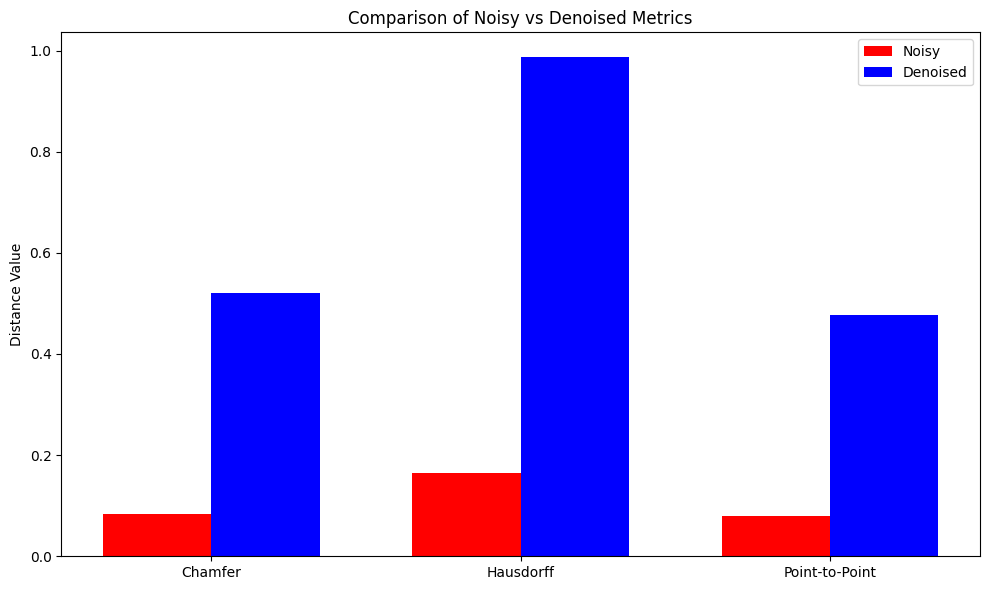

Saved sample 0 to results
Saved sample 1 to results
Saved sample 2 to results
Saved sample 3 to results
Saved sample 4 to results

=== Final Evaluation Summary ===
The model shows the following improvements:
- Chamfer Distance: -0.4369 improvement
- Hausdorff Distance: -0.8228 improvement
- Point-to-Point Distance: -0.3992 improvement


In [ ]:
# 1. Load your test data (assuming you have this from earlier)
test_data = load_dataset_samples('chair', 10)  # Load 10 chair models for testing

# 2. Run the evaluation
metrics = evaluate_denoising_model(model, test_data, num_samples=5, visualize=True)

# 3. Plot metrics comparison
plot_metrics_comparison(metrics)

# 4. Save visual results
save_visual_comparison(model, test_data)

# 5. Print final evaluation summary
print("\n=== Final Evaluation Summary ===")
print("The model shows the following improvements:")
print(f"- Chamfer Distance: {metrics['chamfer_improvement']:.4f} improvement")
print(f"- Hausdorff Distance: {metrics['hausdorff_improvement']:.4f} improvement")
print(f"- Point-to-Point Distance: {metrics['ptp_improvement']:.4f} improvement")